In [1]:
from data_processer import *
import torch
from TimesNet.model import TimesNetConfig, TimesNetForTimeSeriesClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

2025-03-20 12:01:45.111983: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 12:01:45.116796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-20 12:01:45.116809: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_path = "data"
ts_processor = TS_Processor(sequence_length=1024, stride=64, remove_extreme_values=True, iqr_threshold=10.0)
dataset_dict = ts_processor(data_path)

print(dataset_dict)

Detected and removed outliers:
File: 20nm_degree_40.csv, Index: 0, Data: {'time': '2024-12-04 16:14:39.579.', '2-1[m/s^2]': 29.76894, '2-2[m/s^2]': -990.73804, '2-3[m/s^2]': 2.5759, '2-4[m/s^2]': 1015.4796, '2-5[m/s^2]': 0.23558, '2-6[m/s^2]': 0.02296}
File: 100nm_degree_80.csv, Index: 0, Data: {'time': '2024-12-04 18:18:00.273.', '2-1[m/s^2]': 33.15849, '2-2[m/s^2]': 0.58145, '2-3[m/s^2]': -0.53943, '2-4[m/s^2]': -1014.426, '2-5[m/s^2]': -0.22313, '2-6[m/s^2]': 1003.5881}
File: 100nm_degree_40.csv, Index: 0, Data: {'time': '2024-12-04 16:27:52.112.', '2-1[m/s^2]': 31.60742, '2-2[m/s^2]': 991.20013, '2-3[m/s^2]': 1017.3141, '2-4[m/s^2]': 1015.8311, '2-5[m/s^2]': 1003.2505, '2-6[m/s^2]': -1.00929}
File: 60nm_degree_60.csv, Index: 0, Data: {'time': '2024-12-04 17:04:45.059.', '2-1[m/s^2]': -2.50719, '2-2[m/s^2]': -990.35828, '2-3[m/s^2]': 4.05837, '2-4[m/s^2]': 1013.4236, '2-5[m/s^2]': 1003.9898, '2-6[m/s^2]': -1002.5587}
File: 20nm_degree_60.csv, Index: 0, Data: {'time': '2024-12-04 17:

In [3]:
config = TimesNetConfig(
    seq_len=len(dataset_dict["train"][0]["sequence"]),
    d_model=64,
    d_ff=128,
    top_k=2,
    num_kernels=3,
    e_layers=4,
    enc_in=len(dataset_dict["train"][0]["sequence"][0]),
    freq='h',
    embed='timeF',
    dropout=0.05,
    num_class=len(set(dataset_dict["train"]["label"])),
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimesNetForTimeSeriesClassification(configs=config).to(device)

training_args = TrainingArguments(
    output_dir="./results_timesnet",
    evaluation_strategy="steps", 
    eval_steps=200, 
    save_strategy="steps", 
    save_steps=200,
    learning_rate=5e-4,
    load_best_model_at_end=True, 
    metric_for_best_model="eval_loss", 
  #  greater_is_better=True, 
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=50,
    weight_decay=0.01,
    logging_dir="./logs_timesnet",
    logging_steps=50,
    save_total_limit=2,
    label_names=["target_values"],
    remove_unused_columns=False
)


In [4]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=8)]
)

In [5]:
trainer.train()

/home/ubuntu/anaconda3/envs/gpt/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 58035
  Num Epochs = 50
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 90700
  Number of trainable parameters = 2887433
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Accuracy
200,0.996200,1.078203,0.746144
400,0.600800,0.827686,0.808690
600,0.227100,0.212048,0.947001
800,0.263100,1.353277,0.865116
1000,0.106400,0.348037,0.944920
1200,0.146200,0.152917,0.972215
1400,0.151600,0.081888,0.987760
1600,0.201200,0.141357,0.976377
1800,0.078300,0.095480,0.984455
2000,0.051200,0.318262,0.960588


***** Running Evaluation *****
  Num examples = 8170
  Batch size = 32
Saving model checkpoint to ./results_timesnet/checkpoint-200
Configuration saved in ./results_timesnet/checkpoint-200/config.json
Model weights saved in ./results_timesnet/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8170
  Batch size = 32
Saving model checkpoint to ./results_timesnet/checkpoint-400
Configuration saved in ./results_timesnet/checkpoint-400/config.json
Model weights saved in ./results_timesnet/checkpoint-400/pytorch_model.bin
Deleting older checkpoint [results_timesnet/checkpoint-200] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 8170
  Batch size = 32
Saving model checkpoint to ./results_timesnet/checkpoint-600
Configuration saved in ./results_timesnet/checkpoint-600/config.json
Model weights saved in ./results_timesnet/checkpoint-600/pytorch_model.bin
Deleting older checkpoint [results_timesnet/checkpoint-1800] due to args.save_total

TrainOutput(global_step=5400, training_loss=0.17733756043844753, metrics={'train_runtime': 2995.273, 'train_samples_per_second': 968.776, 'train_steps_per_second': 30.281, 'total_flos': 0.0, 'train_loss': 0.17733756043844753, 'epoch': 2.98})

Plot saved to ./plot/timesnet_result.pdf


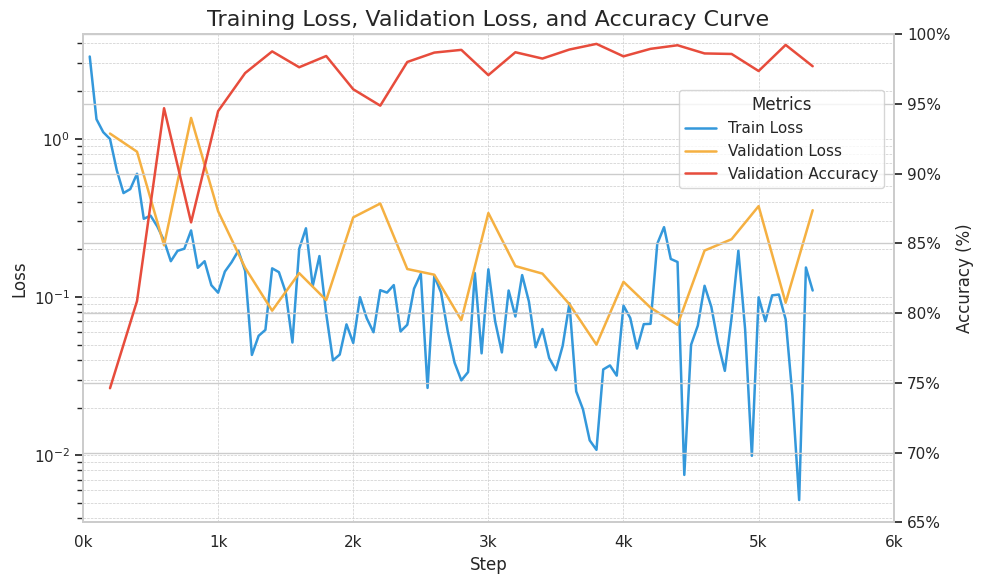

In [7]:
from plot_results import plot_training_results

path = "results_timesnet/checkpoint-5400"
plot_training_results(checkpoint_path=path, save_plot=True, plot_name="timesnet_result")

In [8]:
test_results = trainer.evaluate(eval_dataset=dataset_dict["test"])
test_results

***** Running Evaluation *****
  Num examples = 16484
  Batch size = 32


{'eval_loss': 0.12827181816101074,
 'eval_accuracy': 0.9902329531667071,
 'eval_runtime': 115.3455,
 'eval_samples_per_second': 142.91,
 'eval_steps_per_second': 4.474,
 'epoch': 2.98}